In [1]:
import astropy.io.fits as fits
#import treecorr
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div
import scipy.stats as stats
from more_itertools import locate


data_dir = '/home/b7009348/WGL_project/DES-data/'


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
with fits.open(data_dir+'y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    mcal_e1_m = data['e1']
    mcal_e2_m = data['e2']
    r11_match = data['R11']
    r22_match = data['R22']
    
with fits.open(data_dir+'y1_mcal_flags=0.fits') as hdu:
    data = hdu[1].data
    mcal_e1 = data['e1']
    mcal_e2 = data['e2']
    r11_full = data['R11']
    r22_full = data['R22']
    
del data

## Selection Bias Investigation
- First obtain cuts to make on sheared quantities

In [4]:
with fits.open(data_dir+'y1_mcal_shapes_matched.fits') as hdu:
      match_data = hdu[1].data
        
# print('SNR-Size-rband cut objects:', np.size(data['coadd_objects_id']))
# print('Matched objects:', np.size(match_data['coadd_objects_id']))
      
del data, match_data

NameError: name 'data' is not defined

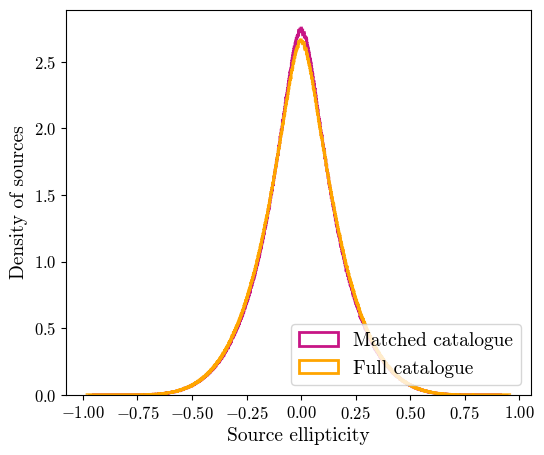

In [47]:
nbins = 1000

e1_binned, e1_bins = np.histogram(mcal_e1, bins=nbins)
e2_binned, e2_bins = np.histogram(mcal_e2, bins=nbins)

np.savez(file='metacalibration_ellipticites_binned_unweighted', e1_counts=e1_binned, 
         e1_bins=e1_bins, e2_counts=e2_binned, e2_bins=e2_bins)

plt.figure(figsize=[6,5])
plt.hist(mcal_e1_m, bins=nbins, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(mcal_e1, bins=nbins, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['Matched catalogue', 'Full catalogue'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('mcal_ellipticity_dist.png', dpi=300)

In [48]:
match_counts, match_bins = np.histogram(mcal_e1_m, bins=1000)
full_counts, full_bins = np.histogram(mcal_e1, bins=1000)

#normalise to get probability dist.
match_pdf = match_counts / np.size(mcal_e1_m)
full_pdf = full_counts / np.size(mcal_e1)

In [49]:
def kl_divergence(p, q):
    """
    Computes the Kullback-Leibler divergence between two distributions p and q.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.where(p != 0, p, np.finfo(float).eps)
    q = np.where(q != 0, q, np.finfo(float).eps)
    kl_div = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return kl_div

kl_divergence(match_pdf, full_pdf)

0.0015508527092138284

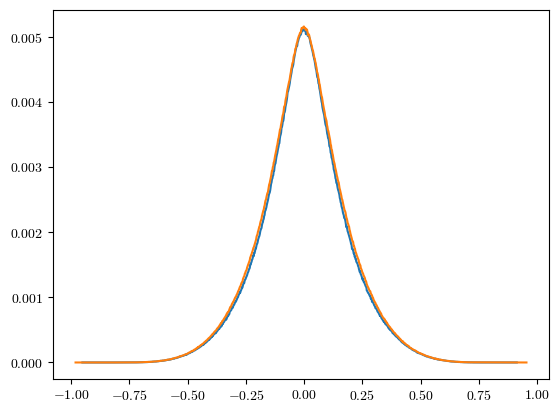

In [24]:
plt.plot(match_bins[:-1], match_pdf)
plt.plot(full_bins[:-1], full_pdf)

In [39]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [43]:
match_e1_mean, match_e1_std = weighted_avg_and_std(mcal_e1_m, weights=r11_match)
print('Matched mean = %e'%match_e1_mean, 'Matched std = %e'%match_e1_std)

full_e1_mean, full_e1_std = weighted_avg_and_std(mcal_e1, weights=r11_full)
print('Full mean = %e'%full_e1_mean, 'Full std = %e'%full_e1_std)

mean_frac = (match_e1_mean - full_e1_mean) / match_e1_mean
print('Fractional change in mean = %g'%mean_frac)

std_frac = (full_e1_std - match_e1_std) / full_e1_std
print('Fractional change in std = %g'%std_frac)

Matched mean = 5.952400e-04 Matched std = 1.719502e-01
Full mean = 5.628005e-04 Full std = 1.740066e-01
Fractional change in mean = 0.0544983
Fractional change in std = 0.0118179
